In [1]:
import pandas as pd

In [2]:
ratings = pd.read_csv(r'filtered_ratings.csv')

In [3]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5.0,2000-12-31 22:12:40
1,1,661,3.0,2000-12-31 22:35:09
2,1,914,3.0,2000-12-31 22:32:48
3,1,3408,4.0,2000-12-31 22:04:35
4,1,2355,5.0,2001-01-06 23:38:11
...,...,...,...,...
997294,6040,1091,1.0,2000-04-26 02:35:41
997295,6040,1094,5.0,2000-04-25 23:21:27
997296,6040,562,5.0,2000-04-25 23:19:06
997297,6040,1096,4.0,2000-04-26 02:20:48


In [4]:
ratings.rename(columns={'Rating': 'rating'}, inplace=True)
ratings.rename(columns={'UserID': 'userId'}, inplace=True)
ratings.rename(columns={'MovieID': 'movieId'}, inplace=True)

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997299 entries, 0 to 997298
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     997299 non-null  int64  
 1   movieId    997299 non-null  int64  
 2   rating     997299 non-null  float64
 3   Timestamp  997299 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 30.4+ MB


In [6]:
ratings['rating'] = ratings['rating'].apply(lambda x: 1 if x > 3.5 else 0)


In [7]:
ratings

,userId,movieId,rating,Timestamp
0,1,1193,1,2000-12-31 22:12:40
1,1,661,0,2000-12-31 22:35:09
2,1,914,0,2000-12-31 22:32:48
3,1,3408,1,2000-12-31 22:04:35
4,1,2355,1,2001-01-06 23:38:11
...,...,...,...,...
997294,6040,1091,0,2000-04-26 02:35:41
997295,6040,1094,1,2000-04-25 23:21:27
997296,6040,562,1,2000-04-25 23:19:06
997297,6040,1096,1,2000-04-26 02:20:48


In [8]:
value_counts = ratings['rating'].value_counts()
value_counts

rating
1    573370
0    423929
Name: count, dtype: int64

In [14]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from collections import Counter

# Assuming ratings DataFrame is already loaded
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Fill NaN with a distinct value (e.g., -1) to differentiate from actual ratings
item_user_matrix_filled = user_item_matrix.T.fillna(-1)

# Compute cosine similarity
item_similarity = cosine_similarity(item_user_matrix_filled)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Create training and testing sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

def get_k_nearest_neighbors(item_similarity_df, movie_id, k=10):
    # Get the similarity scores for the movie with all other movies
    sim_scores = item_similarity_df[movie_id]
    # Sort the movies by similarity score in descending order and select the top k
    nearest_neighbors = sim_scores.sort_values(ascending=False).index[1:k+1]
    return nearest_neighbors

def predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=10):
    # Get k nearest neighbors
    nearest_neighbors = get_k_nearest_neighbors(item_similarity_df, movie_id, k)
    
    # Get the ratings of the user for the nearest neighbors
    neighbor_ratings = user_item_matrix.loc[user_id, nearest_neighbors]
    
    # If there are no ratings by nearest neighbors, return 0
    if neighbor_ratings.isna().all():
        return 0
    
    # Predict the rating based on the majority vote of neighbor ratings
    return Counter(neighbor_ratings.dropna()).most_common(1)[0][0]

# Predict ratings for all users and movies in the test set
y_true_all = []
y_pred_all = []

for index, row in test_ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    y_true_all.append(row['rating'])
    y_pred_all.append(predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=988))

# Convert to integers
y_true_all = [int(val) for val in y_true_all]
y_pred_all = [int(val) for val in y_pred_all]

# Generate classification report
print(classification_report(y_true_all, y_pred_all))


              precision    recall  f1-score   support

           0       0.54      0.83      0.65     84648
           1       0.79      0.48      0.60    114812

    accuracy                           0.63    199460
   macro avg       0.67      0.65      0.63    199460
weighted avg       0.68      0.63      0.62    199460



Classification report for K=5:

              precision    recall  f1-score   support

           0       0.51      0.89      0.65     84648
           1       0.83      0.38      0.52    114812

    accuracy                           0.59    199460
   macro avg       0.67      0.63      0.58    199460
weighted avg       0.69      0.59      0.57    199460



Classification report for K=10:

              precision    recall  f1-score   support

           0       0.53      0.88      0.66     84648
           1       0.82      0.42      0.55    114812

    accuracy                           0.61    199460
   macro avg       0.67      0.65      0.61    199460
weighted avg       0.70      0.61      0.60    199460



Classification report for K=15:

              precision    recall  f1-score   support

           0       0.53      0.87      0.66     84648
           1       0.82      0.43      0.57    114812

    accuracy                           0.62    199460
   macro avg       0.68   

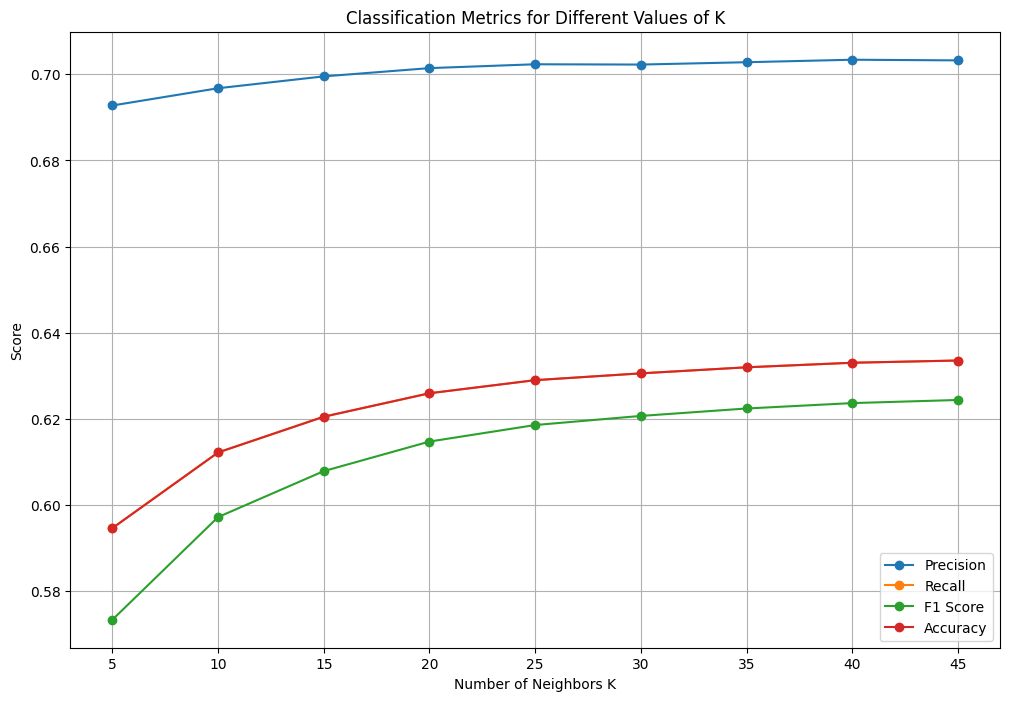

In [9]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Assuming ratings DataFrame is already loaded
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Fill NaN with a distinct value (e.g., -1) to differentiate from actual ratings
item_user_matrix_filled = user_item_matrix.T.fillna(-1)

# Compute cosine similarity
item_similarity = cosine_similarity(item_user_matrix_filled)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Create training and testing sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

def get_k_nearest_neighbors(item_similarity_df, movie_id, k=10):
    # Get the similarity scores for the movie with all other movies
    sim_scores = item_similarity_df[movie_id]
    # Sort the movies by similarity score in descending order and select the top k
    nearest_neighbors = sim_scores.sort_values(ascending=False).index[1:k+1]
    return nearest_neighbors

def predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=10):
    # Get k nearest neighbors
    nearest_neighbors = get_k_nearest_neighbors(item_similarity_df, movie_id, k)
    
    # Get the ratings of the user for the nearest neighbors
    neighbor_ratings = user_item_matrix.loc[user_id, nearest_neighbors]
    
    # If there are no ratings by nearest neighbors, return 0
    if neighbor_ratings.isna().all():
        return 0
    
    # Predict the rating based on the majority vote of neighbor ratings
    return Counter(neighbor_ratings.dropna()).most_common(1)[0][0]

# Define the range for K
k_values = [5,10,15,20,25,30,35,40,45]

# Initialize lists to store metrics
precisions = []
recalls = []
f1_scores = []
accuracies = []

# Loop over the different values of K
for k in k_values:
    # Predict ratings for all users and movies in the test set
    y_true_all = []
    y_pred_all = []

    for index, row in test_ratings.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        y_true_all.append(row['rating'])
        y_pred_all.append(predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=k))

    # Convert to integers
    y_true_all = [int(val) for val in y_true_all]
    y_pred_all = [int(val) for val in y_pred_all]

    # Calculate and store metrics
    precisions.append(precision_score(y_true_all, y_pred_all, average='weighted'))
    recalls.append(recall_score(y_true_all, y_pred_all, average='weighted'))
    f1_scores.append(f1_score(y_true_all, y_pred_all, average='weighted'))
    accuracies.append(accuracy_score(y_true_all, y_pred_all))
    
    # Print classification report for each K
    print(f"Classification report for K={k}:\n")
    print(classification_report(y_true_all, y_pred_all))
    print("\n" + "="*60 + "\n")

# Plot the metrics
plt.figure(figsize=(12, 8))
plt.plot(k_values, precisions, marker='o', label='Precision')
plt.plot(k_values, recalls, marker='o', label='Recall')
plt.plot(k_values, f1_scores, marker='o', label='F1 Score')
plt.plot(k_values, accuracies, marker='o', label='Accuracy')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Score')
plt.title('Classification Metrics for Different Values of K')
plt.legend()
plt.grid(True)
plt.show()
